# P2 Exploration 

Basic exploration will be done in this jupyter notebook. Our exploration is divided into 4 major parts generally and based on the primary events we considered : 
- General exploration
- Feminism
- Space exploration 
- WW2

We would like to finetune DistilBERT on our dataset in order to determine whether movie passed the bechdel test or not:
https://huggingface.co/docs/transformers/en/tasks/sequence_classification 

helpers.py file has intermediate functions that helps us write some code.



In [1]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
 
# Just fill this with wherever is your main data folder is (copy the path just before 'MovieSummaries'):
file_source = "/Users/shrinidhivelan/Downloads/"
#file_source ='/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/'

# Same goes for the reviews dataset : but simply copy the entire path of where your reviews data is... 
reviews_path = "/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv"

# replace the following by the direct path of where your bechdel test movie data is:
bechdel_path = "/Users/shrinidhivelan/Downloads/movies.csv"
#bechdel_path2 = "/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/MovieSummaries/movies_feminism.csv"

### creating dataset by extracting the main CMU data 
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie = create_datasets(file_source, reviews_path)

reviews = pd.read_csv(reviews_path)

MovieMetadata_df['Country dictionnaire'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Genre dictionnaire'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Language dictionnaire'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval)


## 0) General exploration

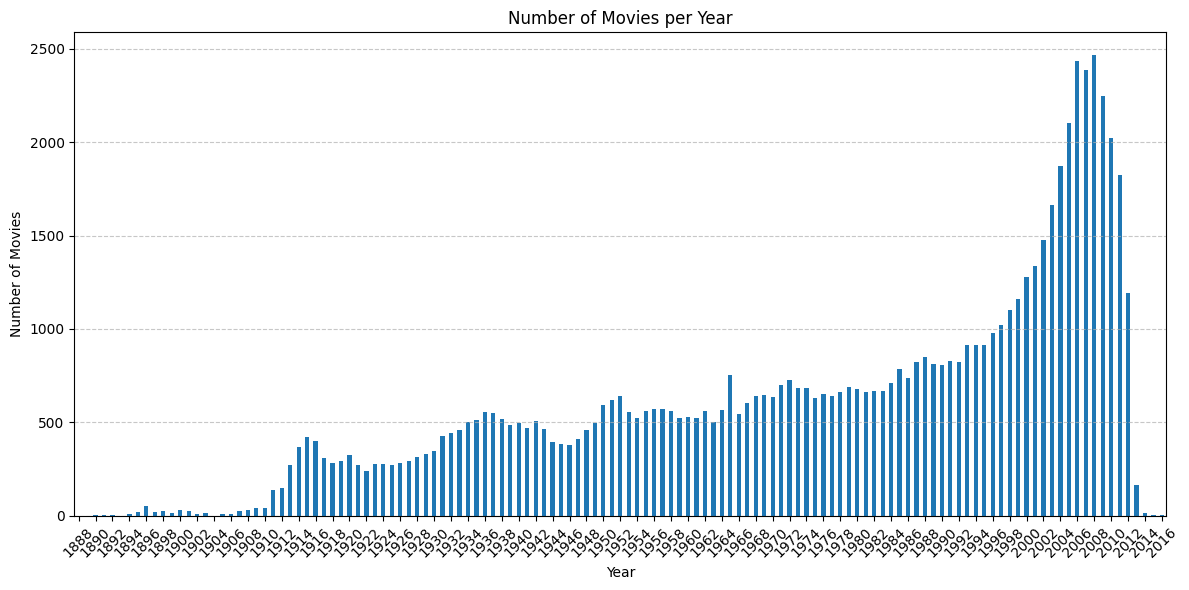

In [4]:
# Count the number of movies per year, ignoring NaN years
movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='bar')
plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Set the x-ticks to display only every 2nd or 3rd year
plt.xticks(ticks=range(0, len(movies_per_year), 2), labels=movies_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

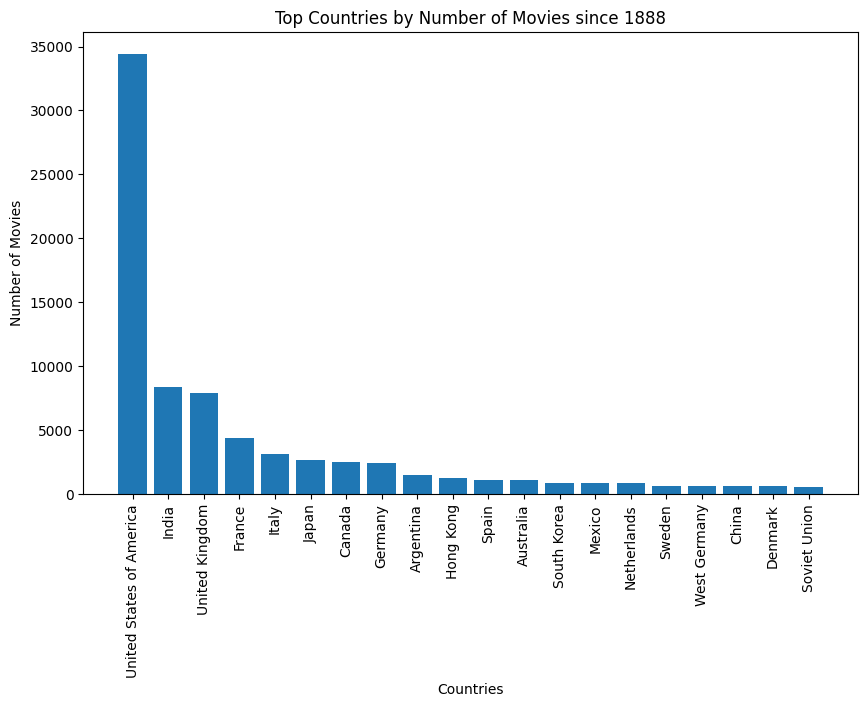

In [7]:
countries_counts = Counter()

for country_dict in MovieMetadata_df['Country dictionnaire']:
    countries_counts.update(country_dict.values())

countries_counts = sorted(countries_counts.items(), key=lambda x: x[1], reverse= True)

countries, counts = zip(*countries_counts)

top_n = 20
countries = countries[:top_n]
counts = counts[:top_n]

plt.figure(figsize=(10, 6))
plt.bar(countries, counts)
plt.xlabel("Countries")
plt.ylabel("Number of Movies")
plt.title("Top Countries by Number of Movies since 1888")
plt.xticks(rotation=90)  
plt.show()

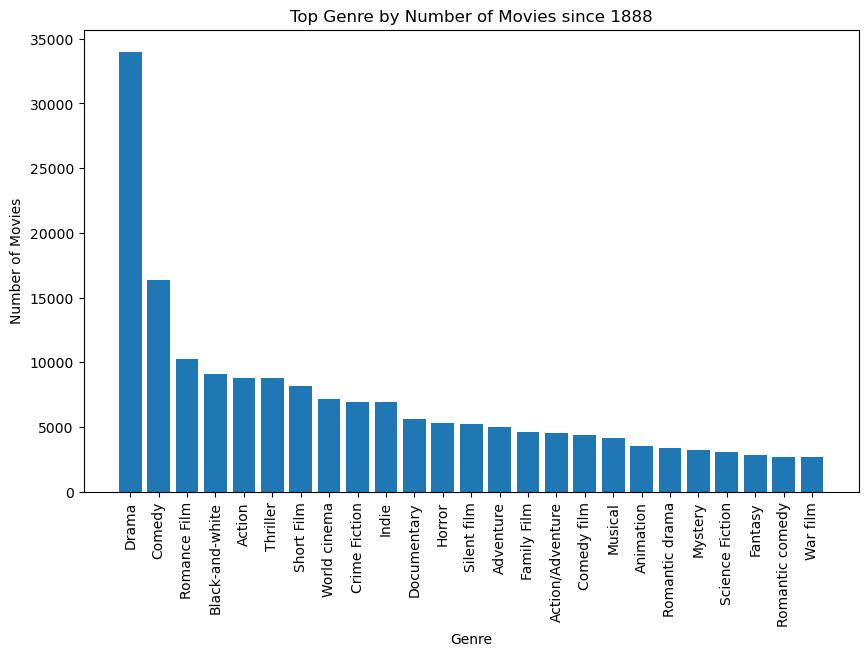

In [5]:
genre_counts = Counter()

for genre_dict in MovieMetadata_df['Genre dictionnaire']:
    genre_counts.update(genre_dict.values())

genre_counts = sorted(genre_counts.items(), key=lambda x: x[1], reverse= True)


genres, counts = zip(*genre_counts)

top_n = 25
genres = genres[:top_n]
counts = counts[:top_n]

plt.figure(figsize=(10, 6))
plt.bar(genres, counts)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Top Genre by Number of Movies since 1888")
plt.xticks(rotation=90)  
plt.show()

## 1) Feminism

### Initial analysis and first steps towards labelling using ML

#### We merge the data on the bechdel test : 
following the ideas of the following site 
https://ai.plainenglish.io/predicting-bechdel-test-score-using-machine-learning-7253618a3f8

In [8]:
# The bechdel data contains ~1700 lines, to be separated into train and test sets in order to create a model to predict the binary result
#### 80% train and 20% test for instance, this will be used to merge main data into this : 
bechdel_data = pd.read_csv(bechdel_path)
bechdel_data = bechdel_data[['year', 'title', 'binary','budget']]
bechdel_data_merged = bechdel_data.merge(MovieMetadata_df, how='left', left_on = 'title', right_on = 'Movie name')

# Define the columns to check for NaN values
columns_to_check = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie release date', 'Movie box office revenue', 'Movie runtime', 
    'Movie languages (Freebase ID:name tuples)', 
    'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)'
]

# Remove rows where all specified columns are NaN
bechdel_data_merged = bechdel_data_merged.dropna(subset=columns_to_check, how='all')

# Display the DataFrame to confirm rows are removed - around ~300 lines are removed
#display(bechdel_data_merged)

####  a) Using the RF classifier

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = bechdel_data_merged  

target = 'result'
features = [
    'year', 'budget', 'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie release date', 'Movie box office revenue', 'Movie runtime', 
    'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)', 'Year'
]

# Convert 'FAIL' to 0 and 'PASS' to 1 in the 'binary' column
df['result'] = df['binary'].replace({'FAIL': 0, 'PASS': 1})


# Drop rows where target is NaN
df = df.dropna(subset=[target])

# Separate features and target variable (X and y constantly)
X = df[features]
y = df[target]

# Define which columns need specific preprocessing
numeric_features = ['year', 'budget', 'Movie box office revenue', 'Movie runtime', 'Year']
categorical_features = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)'
]

# Define preprocessors for a simple random forests  model : 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)#, random_state=42)

# Define and train the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])#(random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_26079/1462372775.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = df['binary'].replace({'FAIL': 0, 'PASS': 1})


Accuracy: 0.61
F1 Score: 0.49
ROC AUC Score: 0.59


### b) Analyze on second bechdel test dataset

In [3]:
# Create a dataframe with the bechdel data as well as plots
bechdel_data2 = pd.read_csv(bechdel_path2)
# drop the NaN movie plots
plot_summaries_df = plot_summaries_df.dropna(subset=['Summaries'])
merged_bechdel_plot = bechdel_plots_dataset_creation(bechdel_data2, MovieMetadata_df,plot_summaries_df)


In [4]:
# Train a model to classify feminist vs non-feminist movies
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

X = merged_bechdel_plot['Summaries']
y = merged_bechdel_plot['bt_score']
X = X.values.reshape(-1, 1)

#balance the dataset
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

#flatten the plots
X_res = pd.Series(X_res.flatten())

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('model', LogisticRegression(solver='liblinear', random_state=42)) 
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7086614173228346

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       137
           3       0.67      0.71      0.69       117

    accuracy                           0.71       254
   macro avg       0.71      0.71      0.71       254
weighted avg       0.71      0.71      0.71       254



In [5]:
# Analyse the information

# Extract the trained model and vectorizer
tfidf = pipeline.named_steps['tfidf']
model = pipeline.named_steps['model']

# Get feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_.flatten()

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Display the top 10 features
print("Top 20 Features with Positive Influence:")
print(feature_importance.head(20))

print("\nTop 20 Features with Negative Influence:")
print(feature_importance.tail(20))

Top 20 Features with Positive Influence:
       Feature  Coefficient
2968    mother     1.810257
3947    school     1.403096
4133    sister     1.286655
2696      love     1.227711
1649    family     1.053197
155      alice     1.030603
1121  daughter     1.010335
2710      lucy     0.899319
2801      mary     0.897330
4931     women     0.894728
2150     house     0.888381
3547     queen     0.872795
2174   husband     0.868736
209      annie     0.858809
781   children     0.844492
2787  marriage     0.778444
1894     girls     0.749941
2126      home     0.738122
3565    rachel     0.733107
3226   parents     0.732355

Top 20 Features with Negative Influence:
          Feature  Coefficient
2326         jack    -0.568910
549          boys    -0.569498
262        arthur    -0.570290
2109       hitman    -0.585387
1047         crew    -0.589181
4607        tramp    -0.617410
2198  illusionist    -0.622951
2385        joker    -0.629301
2467       killed    -0.633486
2338     japanese  

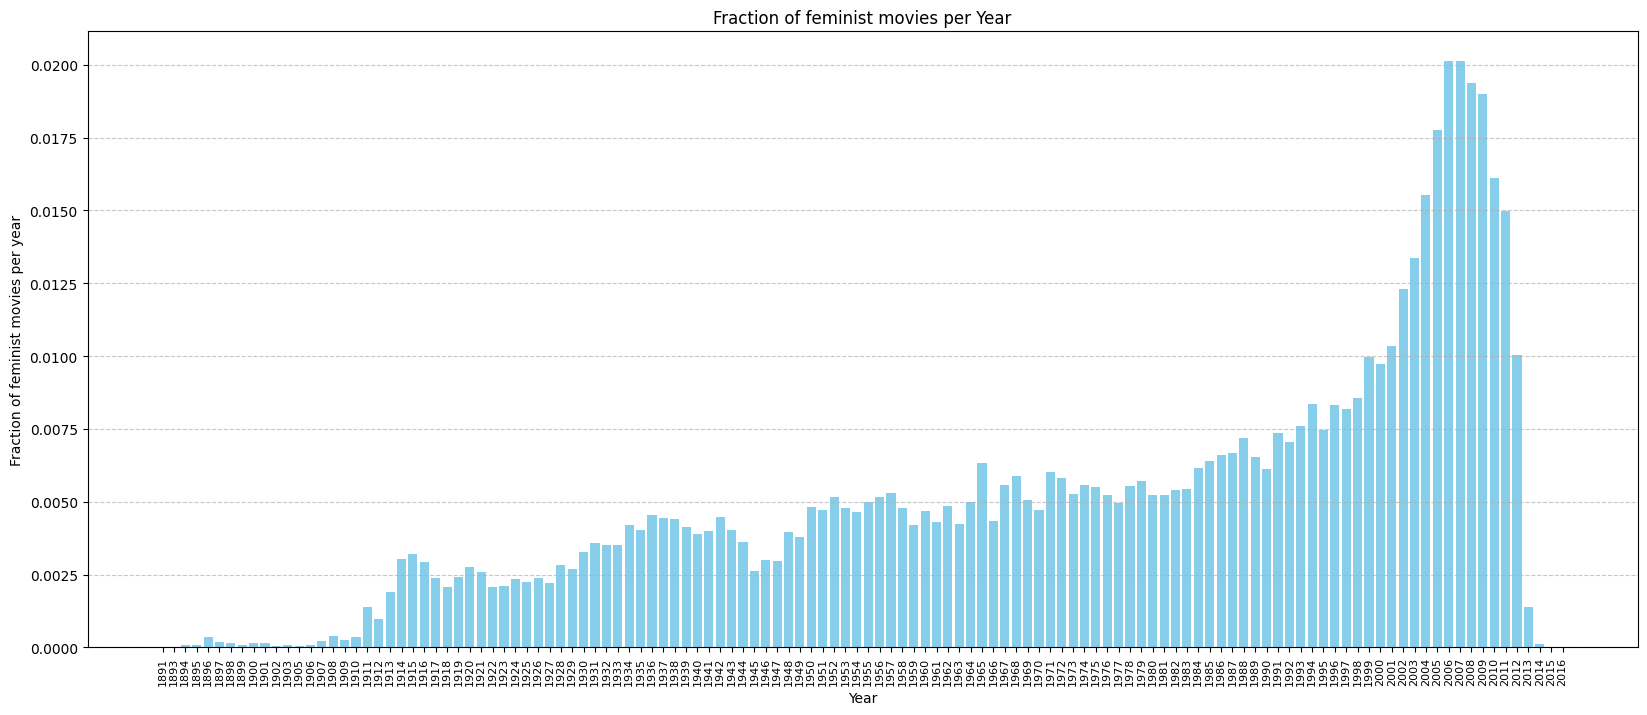

In [11]:
# Predict on all movies
new_predictions = pipeline.predict(plot_summaries_df['Summaries'])

bool_new_predictions = []
for prediction in new_predictions:
    if prediction == 3: 
        bool_new_predictions.append(True)
    else:
        bool_new_predictions.append(False)

# create a new column to keep the prediction
bool_new_predictions = pd.Series(bool_new_predictions)
plot_summaries_df['prediction'] = bool_new_predictions


# Analyse by year
# Add the years to the plots:
filtered_years = filter_years(MovieMetadata_df)
plot_summaries_df['year'] = filtered_years

# Count the number of feminist movies per year
feminist_count = plot_summaries_df[plot_summaries_df['prediction'] == 1]
count_per_year = feminist_count.groupby('year').size().reset_index(name='count')

# Plot the fraction of feminist movies per year
plt.figure(figsize=(20, 8)) 
plt.bar(count_per_year['year'], count_per_year['count']/len(plot_summaries_df))
plt.xlabel('Year')
plt.ylabel('Fraction of feminist movies per year')
plt.title('Fraction of feminist movies per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, fontsize=8) 
plt.show()

## 2) Space-related movies 

### Joint MovieMetadata/ summaries 

In [6]:
MovieMetadata_df_1 = pd.merge(MovieMetadata_df, plot_summaries_df, on = "Wikipedia movie ID", how="inner")

### Selection of space-related movies

For the first analyse, we decided to pick space-related movies according to their plot and some key words in it: 

In [7]:
substrings = ['Space', 'space', 'astronaut', 'Moon', 'moon', 'rocket', 'NASA', 'galaxy', 'planets', 'Apollo', 'black hole', 'gravity', 
              'alien', 'Space Race', 'Spoutnik', 'spaceship', 'light year']

pattern = '|'.join(substrings)

space_movies = MovieMetadata_df_1[MovieMetadata_df_1['Summaries'].str.contains(pattern, case=False, na=False)]

print(space_movies.shape)

(3094, 14)


With these key words, we obtain 3094 space-related movies. We are aware that this method for selecting films is limited. In the third part of the project, we will adjust a model that will determine whether or not a film deals with space-related topics, using a set of films as the training dataset.

### Show the yearly distribution of space related movies

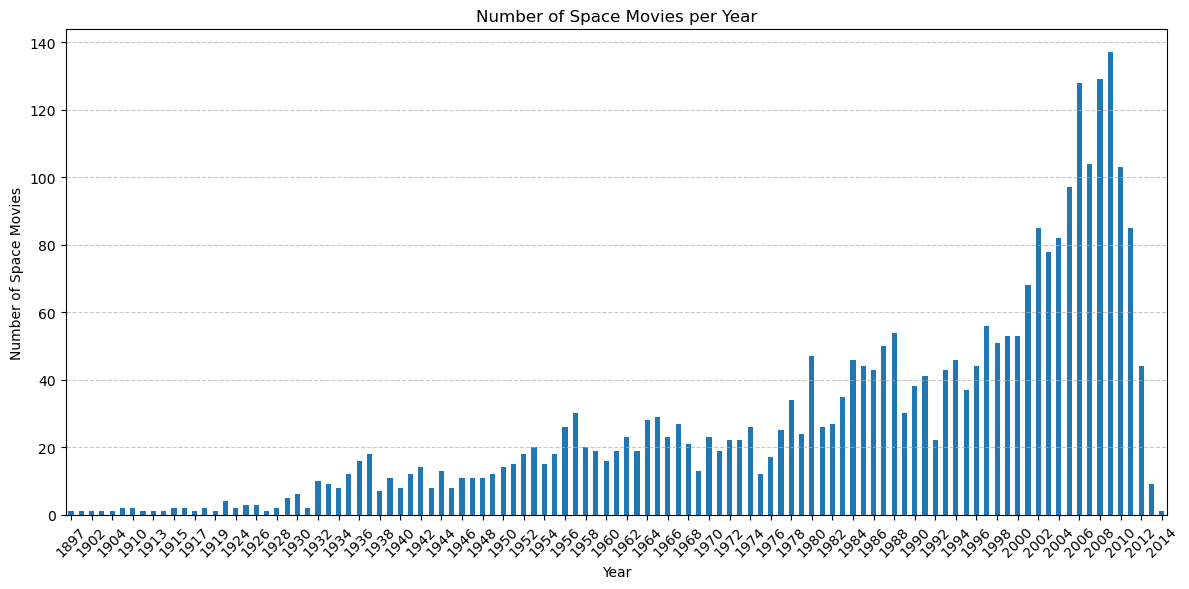

In [8]:
space_movies_per_year =space_movies['Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
space_movies_per_year.plot(kind='bar')
plt.title('Number of Space Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Space Movies')
plt.xticks(ticks=range(0, len(space_movies_per_year), 2), labels=space_movies_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The Space Race began in 1957 with Spoutnik 1 (first satellite to orbit the Earth by the USSR) until 1975: we can on the previous graph a small increase of space-related movies in 1956. 

Boom of such movies in 2000s principally due to special effects technology development.

**Normalize by the number of movies produced each year**

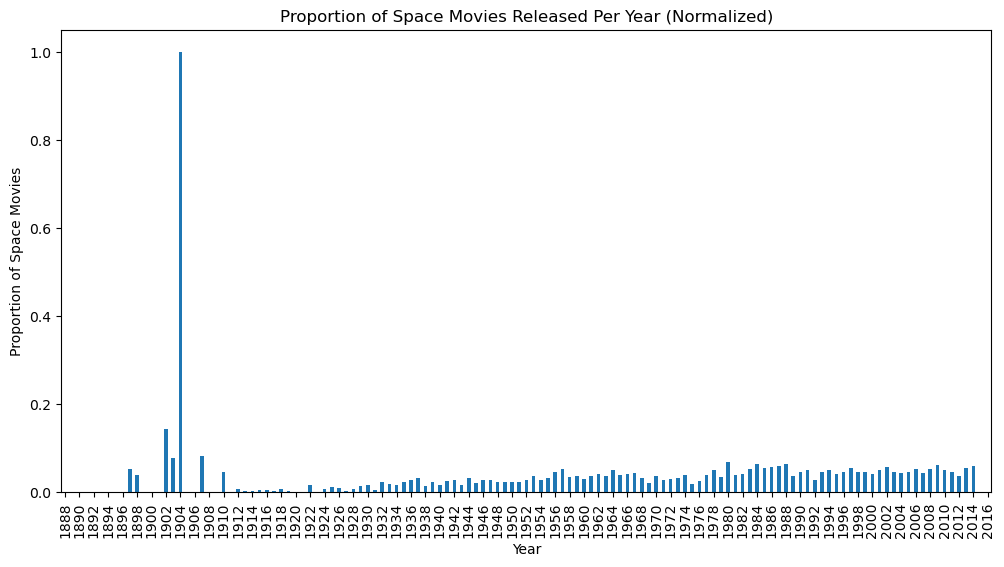

In [9]:
movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index() #number of movies per year

all_years = pd.RangeIndex(start=min(movies_per_year.index.min(), space_movies_per_year.index.min()), 
                          stop=max(movies_per_year.index.max(), space_movies_per_year.index.max()) + 1)

movies_per_year = movies_per_year.reindex(all_years, fill_value=0)
space_movies_per_year = space_movies_per_year.reindex(all_years, fill_value=0)

proportion_space_movies_per_year = (space_movies_per_year / movies_per_year).fillna(0)

plt.figure(figsize=(12, 6))
proportion_space_movies_per_year.plot(kind='bar')
plt.title('Proportion of Space Movies Released Per Year (Normalized)')
plt.xlabel('Year')
plt.ylabel('Proportion of Space Movies')
plt.xticks(ticks=range(0, len(space_movies_per_year), 2), labels=space_movies_per_year.index[::2], rotation=90)
plt.show()

Get rid of the outliers (every year <= 1904) to get a realistic sense of the distribution

In [10]:
space_movies = space_movies[space_movies['Year'] > 1904]

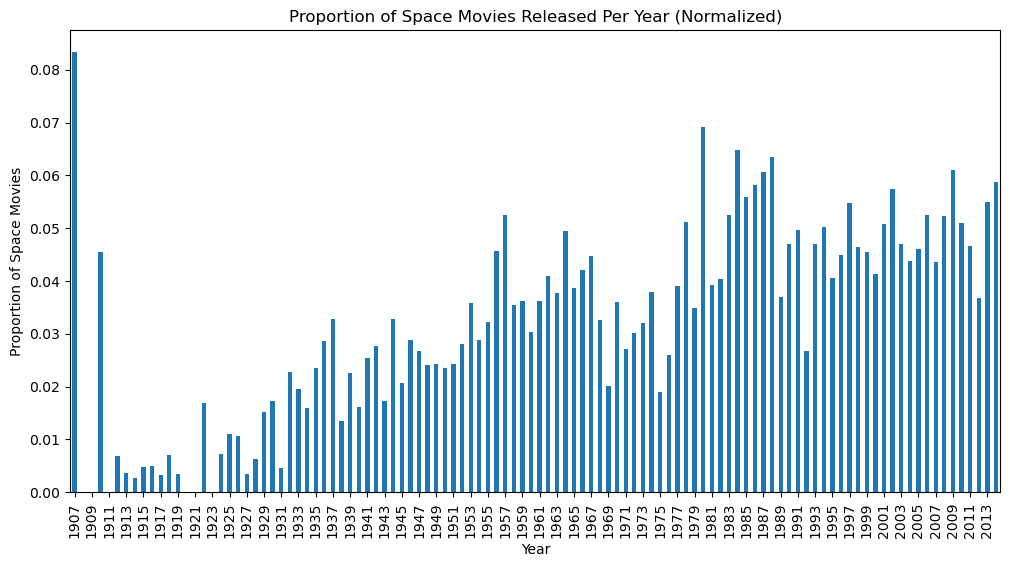

In [11]:
movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index() #number of movies per year
space_movies_per_year =space_movies['Year'].value_counts().sort_index()

all_years = pd.RangeIndex(start=space_movies_per_year.index.min(), 
                          stop=space_movies_per_year.index.max() + 1)

movies_per_year = movies_per_year.reindex(all_years, fill_value=0)
space_movies_per_year = space_movies_per_year.reindex(all_years, fill_value=0)

proportion_space_movies_per_year = (space_movies_per_year / movies_per_year).fillna(0)

plt.figure(figsize=(12, 6))
proportion_space_movies_per_year.plot(kind='bar')
plt.title('Proportion of Space Movies Released Per Year (Normalized)')
plt.xlabel('Year')
plt.ylabel('Proportion of Space Movies')
plt.xticks(ticks=range(0, len(space_movies_per_year), 2), labels=space_movies_per_year.index[::2], rotation=90)
plt.show()

### Number of space-related movies per country:

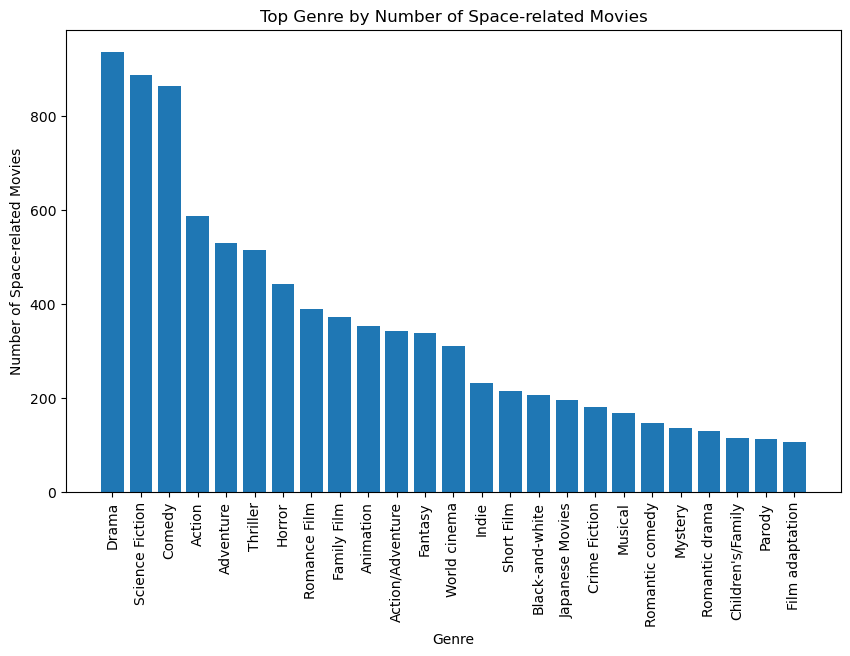

In [12]:
genre_counts_space = Counter()

for genre_dict in space_movies['Genre dictionnaire']:
    genre_counts_space.update(genre_dict.values())

genre_counts_space = sorted(genre_counts_space.items(), key=lambda x: x[1], reverse= True)
#display(genre_counts_space)

genre, counts = zip(*genre_counts_space)

top_n = 25
genre = genre[:top_n]
counts = counts[:top_n]

plt.figure(figsize=(10, 6))
plt.bar(genre, counts)
plt.xlabel("Genre")
plt.ylabel("Number of Space-related Movies")
plt.title("Top Genre by Number of Space-related Movies")
plt.xticks(rotation=90)  # Tourner les noms des pays pour une meilleure lisibilité
plt.show()


### Genre of space movies:

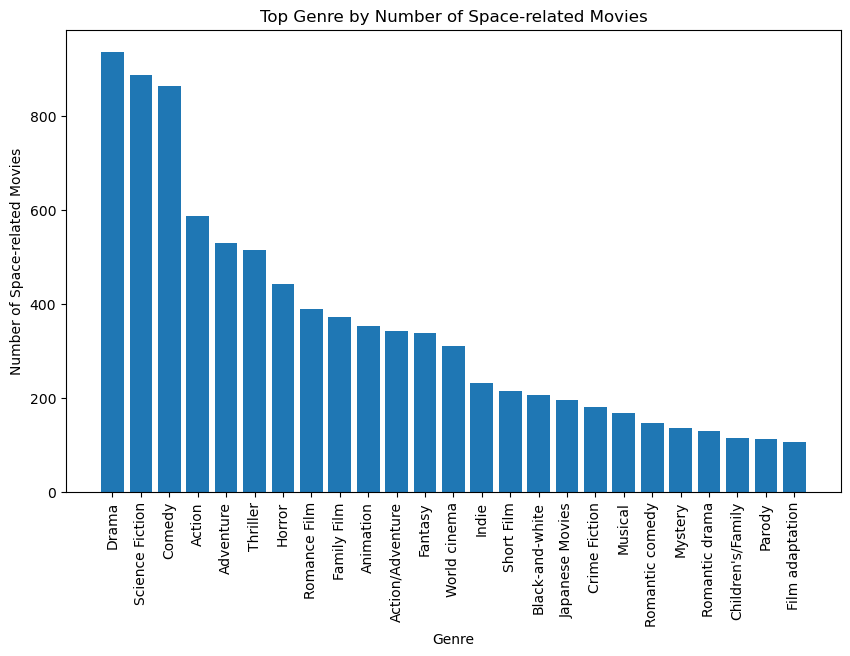

In [13]:
genre_counts_space = Counter()

for genre_dict in space_movies['Genre dictionnaire']:
    genre_counts_space.update(genre_dict.values())

genre_counts_space = sorted(genre_counts_space.items(), key=lambda x: x[1], reverse= True)
#display(genre_counts_space)

genre, counts = zip(*genre_counts_space)

top_n = 25
genre = genre[:top_n]
counts = counts[:top_n]

plt.figure(figsize=(10, 6))
plt.bar(genre, counts)
plt.xlabel("Genre")
plt.ylabel("Number of Space-related Movies")
plt.title("Top Genre by Number of Space-related Movies")
plt.xticks(rotation=90)  # Tourner les noms des pays pour une meilleure lisibilité
plt.show()

### Plot the yearly box office revenue of space related movies

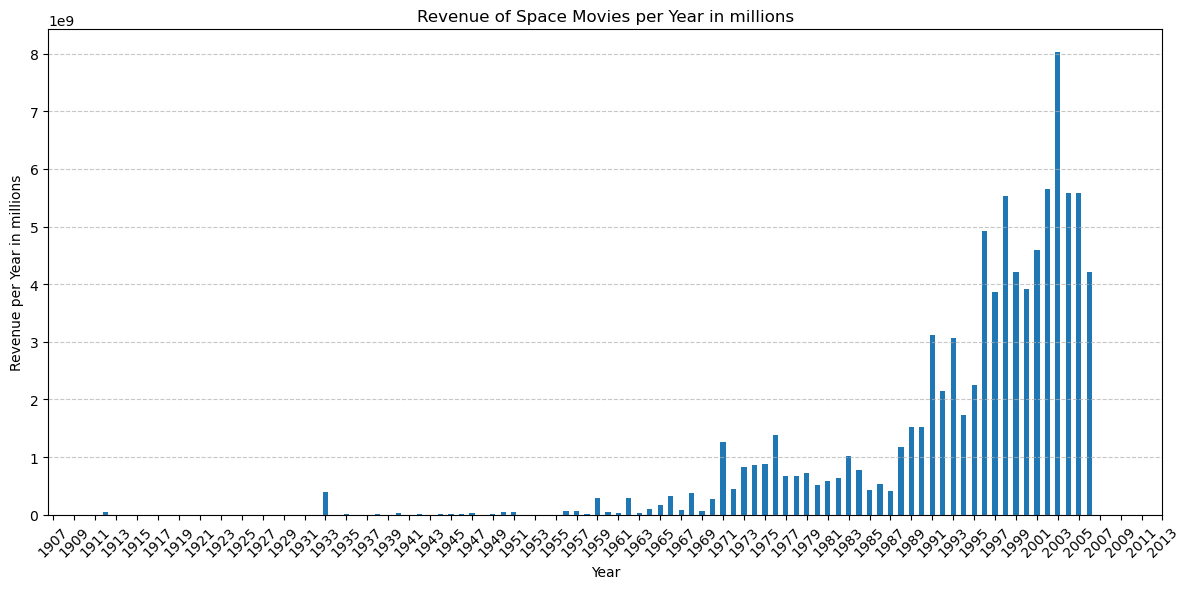

In [14]:
space_revenue_per_year = space_movies.groupby('Year')['Movie box office revenue'].sum()

plt.figure(figsize=(12, 6))
space_revenue_per_year.plot(kind='bar')
plt.title('Revenue of Space Movies per Year in millions')
plt.xlabel('Year')
plt.ylabel('Revenue per Year in millions')
plt.xticks(ticks=range(0, len(space_movies_per_year), 2), labels=space_movies_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Normalize the revenue by the total revenue of movies that year 

Although a reserve can be made about this considering that we do not have box office revenue for every movie of the dataset so this visualization should be taken with consideration.

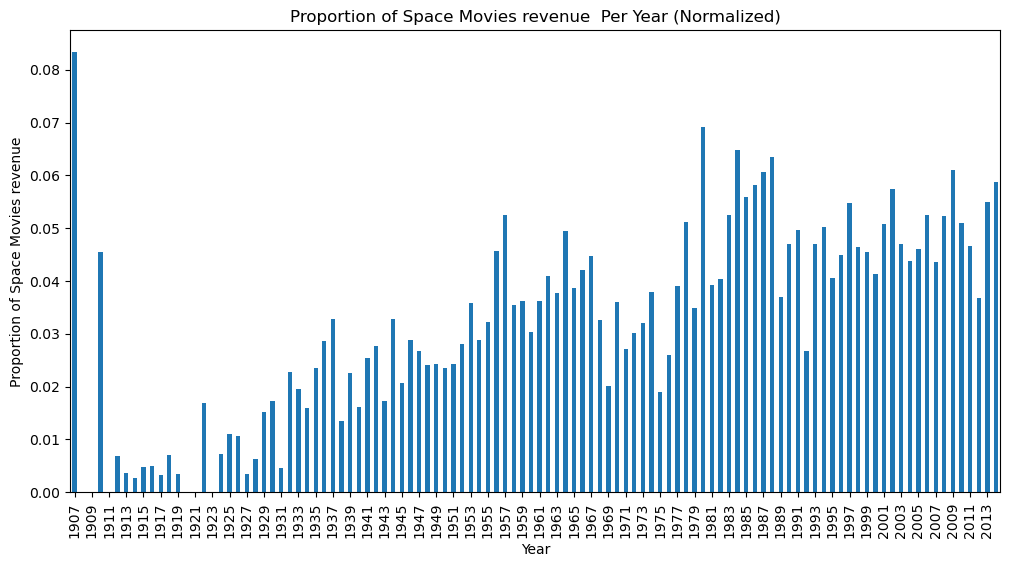

In [15]:
revenue_per_year = MovieMetadata_df.groupby('Year')['Movie box office revenue'].sum()

all_years = pd.RangeIndex(start=min(movies_per_year.index.min(), space_movies_per_year.index.min()), 
                          stop=max(movies_per_year.index.max(), space_movies_per_year.index.max()) + 1)

revenue_per_year = revenue_per_year.reindex(all_years, fill_value=0)
space_revenue_per_year= space_revenue_per_year.reindex(all_years, fill_value=0)

proportion_revenue_space_movies_per_year = (space_movies_per_year / movies_per_year).fillna(0)

plt.figure(figsize=(12, 6))
proportion_revenue_space_movies_per_year.plot(kind='bar')
plt.title('Proportion of Space Movies revenue  Per Year (Normalized)')
plt.xlabel('Year')
plt.ylabel('Proportion of Space Movies revenue')
plt.xticks(ticks=range(0, len(space_movies_per_year), 2), labels=space_movies_per_year.index[::2], rotation=90)
plt.show()

### Print the number of US and USSR made movies on which we have information on box office revenue

In [16]:
# Function to find the country of production of a movie
def find_country(s):
    try:
        start_idx = s.index(': "') + len(': "')
        end_idx = s.index('"', start_idx)
        #print(start_idx, end_idx)
        return s[start_idx:end_idx]
    except ValueError:
        return ""

# Create column with country of production
space_movies['Country'] = space_movies['Movie countries (Freebase ID:name tuples)'].apply(lambda x: find_country(x))

# Find out if the country of production is either the USA or part of the USSR
us_space_movies = space_movies[space_movies['Country'] == 'United States of America']
ussr_space_movies = space_movies[space_movies['Country'].isin([
    'Czechoslovakia', 'German Democratic Republic', 'Hungary', 
    'Poland', 'Romania', 'Uzbekistan', 'Soviet Union'
])]

In [17]:
print('Number of US movies that are related to the space race : ' , us_space_movies.shape[0])
print('Number of US movies related to the space race with box office revenue information : ', us_space_movies['Movie box office revenue'].dropna().shape[0])

Number of US movies that are related to the space race :  1846
Number of US movies related to the space race with box office revenue information :  778


In [18]:
print('Number of USSR movies that are related to the space race : ' , ussr_space_movies.shape[0])
print('Number of USSR movies related to the space race with box office revenue information : ', ussr_space_movies['Movie box office revenue'].dropna().shape[0])

Number of USSR movies that are related to the space race :  23
Number of USSR movies related to the space race with box office revenue information :  0


## 3) World War II and War Movies

### Selection of "War Movies"

Note that the keywords used here to qualify a movie as "war-related" may be unsufficient or unprecise and should be refined during the project. 

The following is an exploratory analysis aiming to observe some expected effects of World War II in the popularity of war-related movies, to assess future prospects of analysis of our data. 

In [7]:
# The strings we are going to look for
substrings_war = ['World War', 'World war', 'world war', 'War ', 'war ', ' war', ' War']
pattern_war = '|'.join(substrings_war)

# Filter based on summaries containing war-related terms
war_movies_df = MovieMetadata_df_1[MovieMetadata_df_1['Summaries'].str.contains(pattern_war, case=False, na=False)]

# Filter for movies labeled as "War" genre by the original dataset
genre_war_movies = MovieMetadata_df[MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].str.contains('War', case=False, na=False)]

# Ensure the columns that might contain dictionaries are converted to string (or handled appropriately)
war_movies_df = war_movies_df.applymap(lambda x: str(x) if isinstance(x, dict) else x)
genre_war_movies = genre_war_movies.applymap(lambda x: str(x) if isinstance(x, dict) else x)

# Combine both criteria-based lists of movies
war_movies_df = pd.concat([war_movies_df, genre_war_movies], ignore_index=True).drop_duplicates()


/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_28069/2233020784.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  war_movies_df = war_movies_df.applymap(lambda x: str(x) if isinstance(x, dict) else x)
/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_28069/2233020784.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genre_war_movies = genre_war_movies.applymap(lambda x: str(x) if isinstance(x, dict) else x)


### Evolution in number of War Movies Produced

We count the number of movies related to war produced every year and plot the evolution of these values

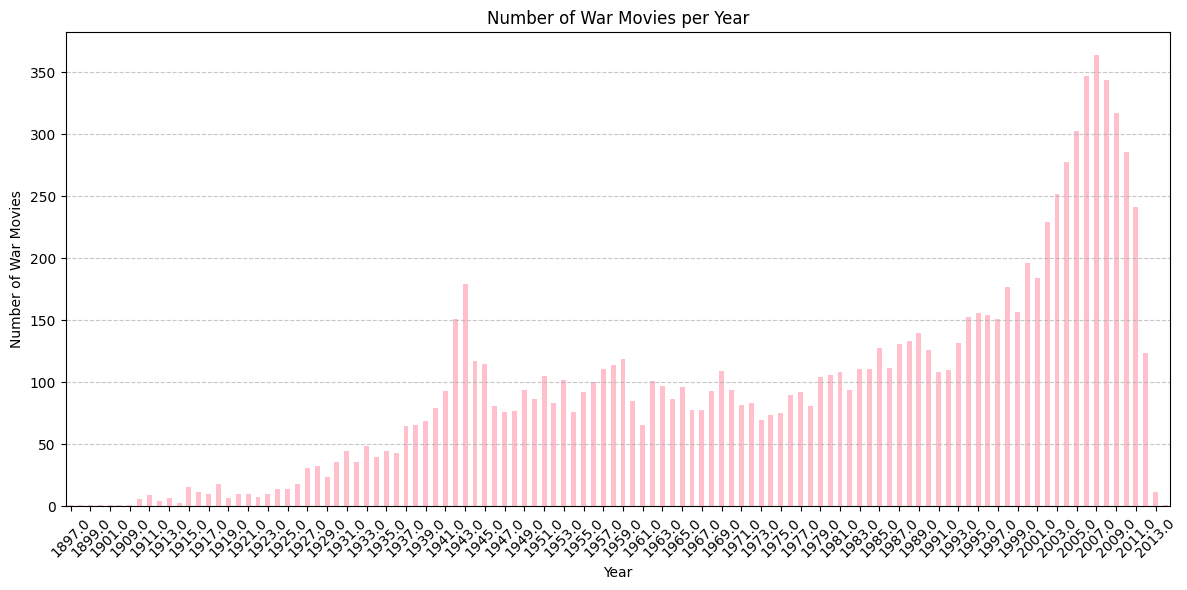

In [8]:
war_movies_per_year =war_movies_df['Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
war_movies_per_year.plot(kind='bar', color='pink')
plt.title('Number of War Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of War Movies')
plt.xticks(ticks=range(0, len(war_movies_per_year), 2), labels=war_movies_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

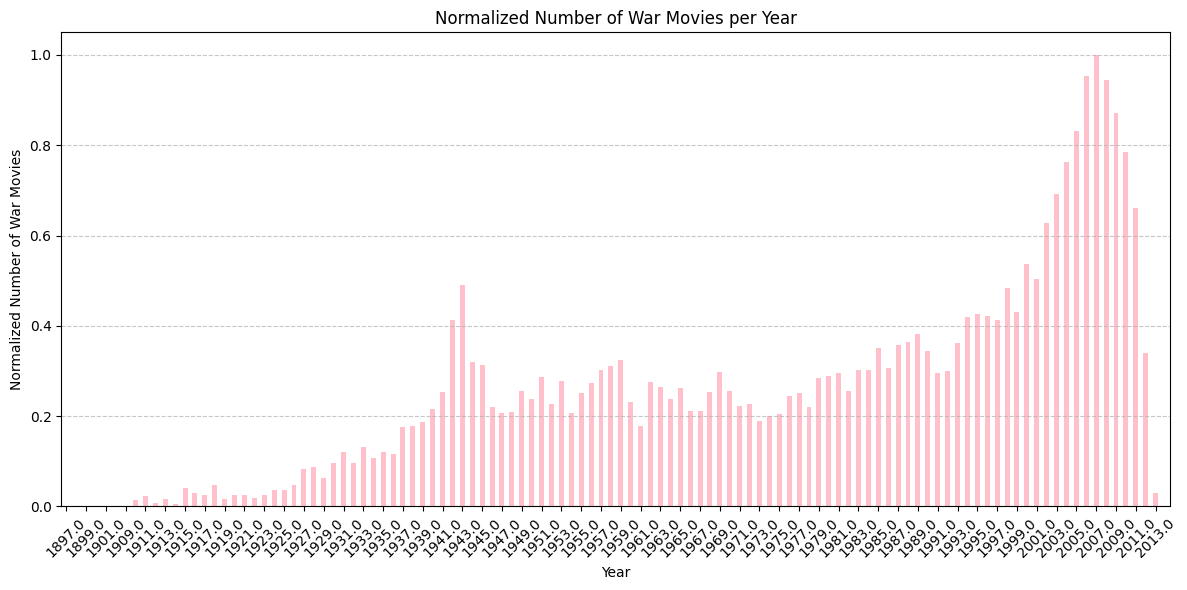

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

# Reshape data for MinMaxScaler, as it expects a 2D array
war_movies_per_year_values = war_movies_per_year.values.reshape(-1, 1)

# Initialize the scaler and fit-transform the data
scaler = MinMaxScaler(feature_range=(0, 1))
war_movies_per_year_normalized = scaler.fit_transform(war_movies_per_year_values)

# Convert back to a Series with the same index for easy plotting
war_movies_per_year_normalized = pd.Series(war_movies_per_year_normalized.flatten(), index=war_movies_per_year.index)

# Plot the normalized data
plt.figure(figsize=(12, 6))
war_movies_per_year_normalized.plot(kind='bar', color='pink')
plt.title('Normalized Number of War Movies per Year')
plt.xlabel('Year')
plt.ylabel('Normalized Number of War Movies')
plt.xticks(ticks=range(0, len(war_movies_per_year_normalized), 2), labels=war_movies_per_year_normalized.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

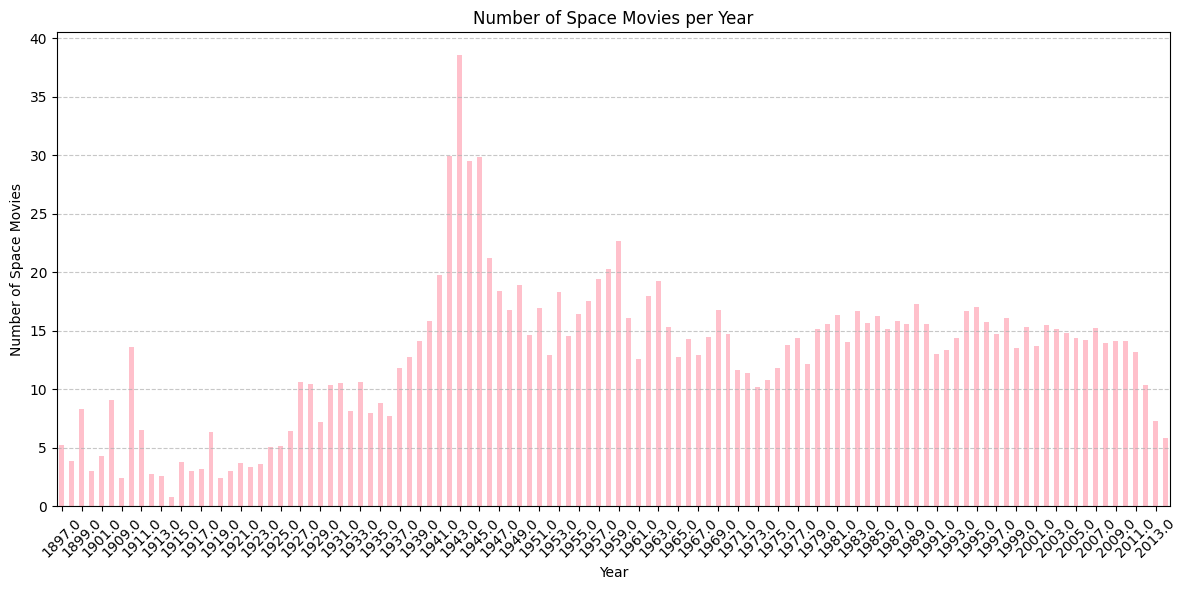

In [11]:
war_movies_proportion_per_year = (war_movies_per_year / movies_per_year * 100).dropna()

plt.figure(figsize=(12, 6))
war_movies_proportion_per_year .plot(kind='bar', color='pink')
plt.title('Number of Space Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Space Movies')
plt.xticks(ticks=range(0, len(war_movies_proportion_per_year), 2), labels=war_movies_proportion_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can already see a peak around 1940 but we also have to agknowledge the increase in movie release over the years, and therefore normalize by the total number of movies producedeach year to get a proportion in percentage. 

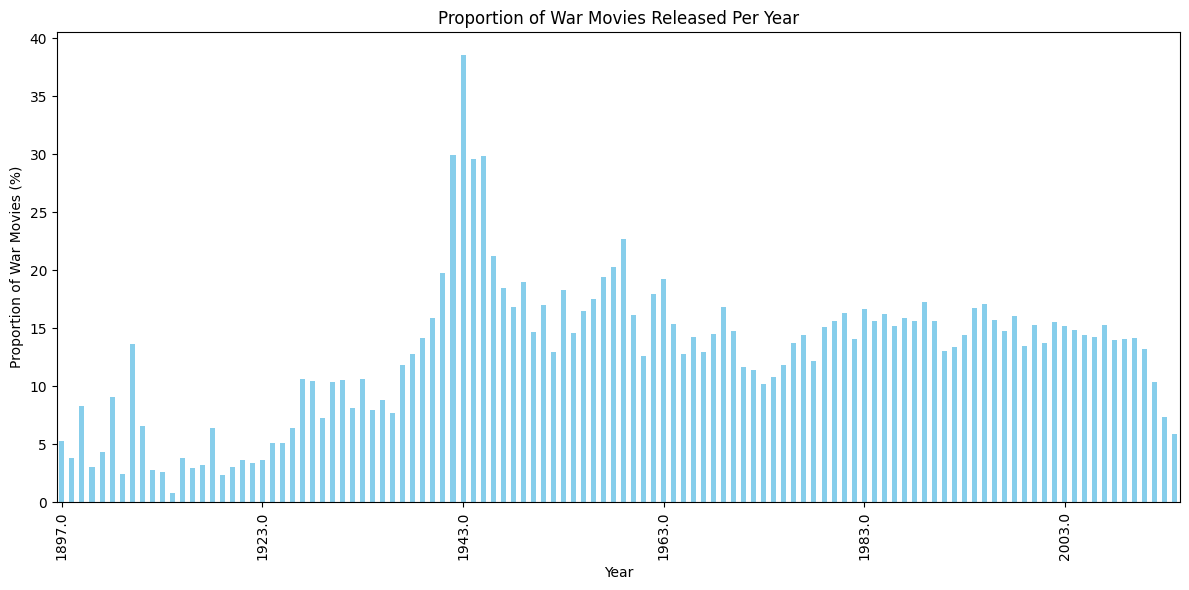

In [12]:
# Reindex movies_per_year to match war_movies_per_year and fill missing years with zeros
movies_per_year = movies_per_year.reindex(war_movies_per_year.index, fill_value=0)

# Calculate the proportion of war movies per year and drop any NaN values
war_movies_proportion_per_year = (war_movies_per_year / movies_per_year * 100).dropna()

# Check if war_movies_proportion_per_year is empty
if war_movies_proportion_per_year.empty:
    print("No data available for war movies proportion per year.")
else:
    # Plotting
    plt.figure(figsize=(12, 6))
    war_movies_proportion_per_year.plot(kind='bar', color='skyblue')
    plt.title('Proportion of War Movies Released Per Year')
    plt.xlabel('Year')
    plt.ylabel('Proportion of War Movies (%)')
    
    # Set x-ticks to show every 20th year for readability
    tick_positions = range(0, len(war_movies_proportion_per_year), 20)
    tick_labels = war_movies_proportion_per_year.index[tick_positions]
    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=90)
    
    plt.tight_layout()
    plt.show()


This statistic gives us the results one could expect: a net peak around the 1940's when war was the most omnipresent subject there could be. 

### War movies box office values fluctuation 

One could argue that it could just be a high number of small movies being produced inspired by the recent events, but maybe not being successful in the process. 

We now try to observe fluctuations in the box office revenues registered for war movies across the years, symbolizing the quantity of people willing to pay to see them. 

In [ ]:
# Calculate Total Box Office Revenue Per Year for All Movies
total_revenue_per_year = MovieMetadata_df.groupby('Year')['Movie box office revenue'].sum()

# Calculate Total Box Office Revenue for World War Movies Per Year
war_revenue_per_year = war_movies_df.groupby('Year')['Movie box office revenue'].sum()

We can see the graph already has a different shape than expected. We then divide by the total box office revenue for every movie of each year.  

([<matplotlib.axis.XTick at 0x2fb494c50>,
 [Text(0, 0, '1897.0'),
  Text(2, 0, '1915.0'),
  Text(4, 0, '1921.0'),
  Text(6, 0, '1923.0'),
  Text(8, 0, '1925.0'),
  Text(10, 0, '1927.0'),
  Text(12, 0, '1929.0'),
  Text(14, 0, '1931.0'),
  Text(16, 0, '1933.0'),
  Text(18, 0, '1935.0'),
  Text(20, 0, '1937.0'),
  Text(22, 0, '1939.0'),
  Text(24, 0, '1941.0'),
  Text(26, 0, '1943.0'),
  Text(28, 0, '1945.0'),
  Text(30, 0, '1947.0'),
  Text(32, 0, '1949.0'),
  Text(34, 0, '1951.0'),
  Text(36, 0, '1953.0'),
  Text(38, 0, '1955.0'),
  Text(40, 0, '1957.0'),
  Text(42, 0, '1959.0'),
  Text(44, 0, '1961.0'),
  Text(46, 0, '1963.0'),
  Text(48, 0, '1965.0'),
  Text(50, 0, '1967.0'),
  Text(52, 0, '1969.0'),
  Text(54, 0, '1971.0'),
  Text(56, 0, '1973.0'),
  Text(58, 0, '1975.0'),
  Text(60, 0, '1977.0'),
  Text(62, 0, '1979.0'),
  Text(64, 0, '1981.0'),
  Text(66, 0, '1983.0'),
  Text(68, 0, '1985.0'),
  Text(70, 0, '1987.0'),
  Text(72, 0, '1989.0'),
  Text(74, 0, '1991.0'),
  Text(76, 0,

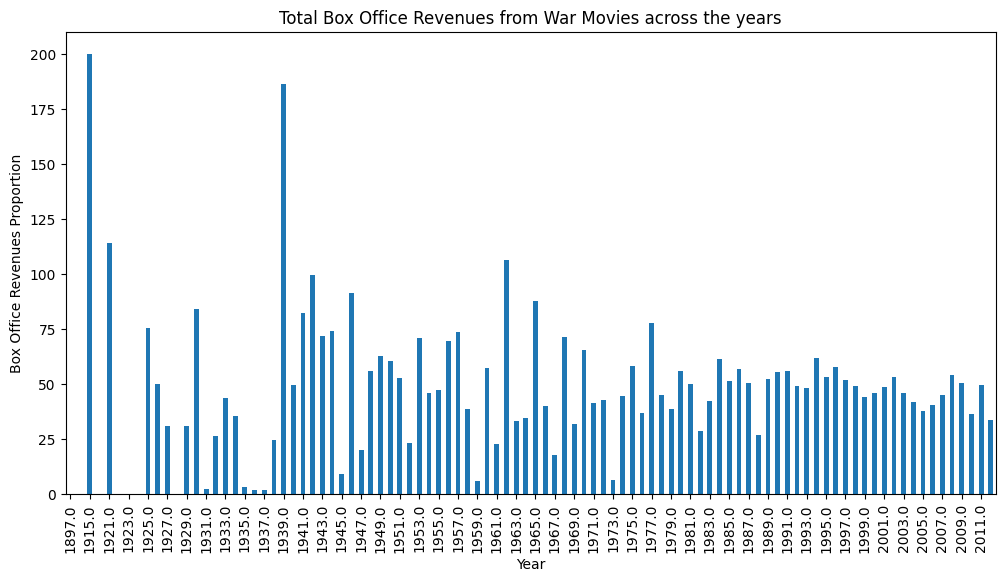

In [17]:
# Calculate the Percentage of Box Office Revenue
war_revenue_proportion_per_year = (war_revenue_per_year / total_revenue_per_year * 100).dropna()

plt.figure(figsize=(12, 6))
war_revenue_proportion_per_year.plot(kind='bar')
plt.title('Total Box Office Revenues from War Movies across the years')
plt.xlabel('Year')
plt.ylabel('Box Office Revenues Proportion')
plt.xticks(ticks=range(0, len(war_revenue_proportion_per_year), 2), labels=war_revenue_proportion_per_year.index[::2], rotation=90)

We get less conclusive results than earlier, which could be attributed to fluctuation in the value of money itself, but let's first take a look at our data and nan values:

In [18]:
nan_count = MovieMetadata_df['Movie box office revenue'].isna().sum()

print(f"Number of NaN values for the box office revenue: {nan_count} out of {len(MovieMetadata_df['Movie box office revenue'])}, ({round(100*nan_count/len(MovieMetadata_df['Movie box office revenue']), 0)}%)")

Number of NaN values for the box office revenue: 73340 out of 81741, (90.0%)


This result means we will probably need to find another dataset to fill the missing values in our to have a meaningful analysis of box office values. 